### Author: Feng Ling, Michael Lees and Debraj Roy

---
The MIT License (MIT)

Copyright (c) 2015 Michael Lees, Debraj Roy

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---

# Viral Marketing using NetworkX

Social network platforms like Facebook or Twitter is becoming major sources of information channels. On these new media platforms, everyone acts as both information generator and consumer. In a sense, the spreading of information, and broadly speaking, opinions, shares much resemblance with disease spreading, in which the information/opinion is the virus jumping from one person to another. Hence the term 'viral marketing' is used to define the information that goes viral over social networks space, much like an epidemic.




## SIR model in disease spreading and information spreading.


In the context of Twitter, a particular tweet that originates from a single or a group of Twitter accounts.  The traditional SIR model in disease spreading can be mapped onto information spreading as follows:

1. Susceptible - a person has not retweeted the particular tweet (the disease).

2. Infected - the person has retweeted it and the retweet remains visible to its followers on Twitter, such that the followers have a chance to retweet it.

3. Removed -  the person has retweeted sometime ago, and the retweet from him/her is no longer visible by the followers. Thus this person is not going to retweet the same information again, and none of its followers would retweet from him/her due to the lack of visibility.

It has been pointed out that empirical evidence do not always support the original SIR model mechanism in information spreading, while certain variations of SIR would capture the real spreading behaviors of people better. But for the sake of simplicity, we are only going to cover the original SIR model for this class.

Since we are using the same SIR model for information spreading, the model setting is the same as session '4. Epidemic spreading using NetworkX'. $\beta$ is the probability that an infected node spreads the information to each of its susceptible neighbors in each simulation time step. $\alpha$ is the probability that an infected node recovers in each simulation time step. This process resembles a 'bond-percolation' process in statistical physics.


## The problem

The problem we are addressing is the maximization of viral spreading through selecting the best set of seed nodes. This means given a piece of information (say a Tweet) with fixed $\beta$ and $\alpha$ values, what are the best seed nodes to infect in the initialisation round, such that the information can reach the widest population. Mathematically, if we define $T$ as the expected number of people who would retweet the information eventually, how to select the initial nodes to maximize the value of $T$. To estimate a reliable $T$ value, we need to run multiple simulations (Monte Carlo) for each initialization to get the average $\langle T\rangle $ value. 


## The code
    
Since the mechanism in this information spreading model is assumed to be the same as the epidemic spreading model in the previous session, we will build upon the previous codes for this tutorial.
    
We first start with importing libraries and network data.


In [1]:
import networkx as nx #import NetworkX
import numpy as np #import numpy for ...
#force drawing of graphs inline for ipython notebook
%matplotlib inline 
import matplotlib.pyplot as plt #import matplotlib for plotting/drawing grpahs
import matplotlib.patches as mpatches #for legends in the graph
from __future__ import unicode_literals #allow UTF characters in graph labels
import random # for random choice function
from tqdm import tqdm #nice library for progress bars
import sys #for printing to screen in a special way
import operator #standard python library used for sorting
from enum import * # used for the states S,I,R

## Python functions

The functions are mostly from the previous session, with the exceptions of initialise_infection() and its related lines in the other functions. The initialisation is critical to this problem since it determines the final $\langle T \rangle$ value.


In [24]:
class State(Enum): # define the three states of the nodes.
    Succeptible = 0
    Infected = 1
    Removed = 2
    
def reset(G):
    """ 
    :param G: The graph to reset
    
    Initialise/reset all the nodes in the network to be succeptible. 
    Used to initialise the network at the start of an experiment
    """
    nx.set_node_attributes(G, name='state', values=State.Succeptible)
        

        
def initialise_infection_random(G, num_to_infect):
    """
    :param G: Graph to infect nodes on
    :param num_to_infect: Number of nodes to infect on G
    
    Set the state of a random selection of nodes to be infected. 
    numToInfect specifices how many infections to make, the nodes 
    are chosen randomly from all nodes in the network
    """
    nodes_to_infect = random.sample(G.nodes(), num_to_infect)
    for n in nodes_to_infect:
        G.node[n]['state'] = State.Infected
    return nodes_to_infect

def transmission_model_factory(beta=0.03, alpha=0.05):
    """
    :param beta: specifies the rate of infection (movement from S to I)
    :param alpha: specifies the rate of removal (movement from I to R)
    :returns: a function specifying infection model.
    
    Creates and returns an instance of a infection model. This allows us 
    to create a number of models with different beta and alpha parameters.
    Note that in a single time step an infected node can infect their neighbours
    and then be removed.
    """
    def m(n, G):
        if G.node[n]["state"] == State.Infected:
            # infect susceptible neighbours with probability pInfect
            for k in G.neighbors(n):
                if G.node[k]['state'] == State.Succeptible:
                    if random.random() <= beta:
                        G.node[k]['state'] = State.Infected
            if random.random() <= alpha:
                G.node[n]['state'] = State.Removed                
    return m

def execute_one_step(G, model):
    """
    :param G: the Graph on which to execute the infection model
    :param model: model used to infect nodes on G

    executes the infection model on all nodes in G
    """
    for n in G:
        model(n, G)

def get_infection_stats(G):
    """
    :param G: the Graph on which to execute the infection model
    :returns: a tuple containing three lists of succeptible, infected and removed nodes.

    Creates lists of nodes in the graph G that are succeptible, infected and removed.
    """
    infected = []
    succeptible = []
    removed = []
    for n in G:
        if G.node[n]["state"] == State.Infected:
            infected.append(n)
        elif G.node[n]['state'] == State.Succeptible:
            succeptible.append(n)
        else:
            removed.append(n)
    return succeptible, infected, removed


def print_infection_stats(G):
    """
    :param G: the Graph on which to execute the infection model

    Prints the number of succeptible, infected and removed nodes in graph G.
    """
    s,i,r = get_infection_stats(G)
#     print "Succeptible: %d Infected: %d Removed %d"% (len(s),len(i),len(r))

def run_spread_simulation(G, model, initially_infected, run_visualise=False):
    """
    :param G: the Graph on which to execute the infection model
    :param model: model used to infect nodes on G
    :param initial_infection_count: Number of nodes to infect on G
    :param run_visualise: if set to true a visual representation of the network 
                          will be written to file at each time step
    :returns : a 5-tuple containing, list of S,I,R nodes at end, the end time 
               and the list of initially infected nodes (useful for visulisation)

    Runs a single simulation of infection on the graph G, using the specified model. 
    An initial infection count is specified to infect a set of nodes. 
    The simulation is executed until there are no more infected nodes, that is the 
    infection dies out, or everyone ends up removed.
    """
    #initially_infected = initialise_infection_degree(G, initial_infection_count)

    s_results = []
    i_results = []
    r_results = []

    dt = 0
    s,i,r = get_infection_stats(G)
    
    pos = nx.spring_layout(G, k=.75)
    
    while len(i) > 0:
        execute_one_step(G, model)
        dt += 1
        s,i,r = get_infection_stats(G)
        s_results.append(len(s))
        i_results.append(len(i))
        r_results.append(len(r))
        sys.stderr.write('\rInfected: %d time step: %d' % (len(i), dt))
        sys.stderr.flush()
        if run_visualise:
            draw_network_to_file(G,pos,dt,initially_infected)
    return s_results, i_results, r_results, dt, initially_infected

def plot_infection(S,I,R,G):
    """
    :param S: time-ordered list from simulation output indicating how succeptible count changes over time
    :param I: time-ordered list from simulation output indicating how infected count changes over time
    :param R: time-ordered list from simulation output indicating how removed count changes over time
    :param G: Graph of statistic to plot
   
    Creates a plot of the S,I,R output of a spread simulation.
    """
    peak_incidence = max(I)
    peak_time = I.index(max(I))
    total_infected = S[0]-S[-1]

    fig_size= [18,13]
    plt.rcParams.update({'font.size': 14, "figure.figsize": fig_size})
    xvalues = range(len(S))
    plt.plot(xvalues, S, color='g', linestyle='-', label="S")
    plt.plot(xvalues, I, color='b', linestyle='-', label="I")
    plt.plot(xvalues, R, color='r', linestyle='-', label="R")
    plt.axhline(peak_incidence, color='b', linestyle='--', label="Peak Indidence")
    plt.annotate(str(peak_incidence),xy=(1,peak_incidence+10), color='b')
    plt.axvline(peak_time, color='b', linestyle=':', label="Peak Time")
    plt.annotate(str(peak_time),xy=(peak_time+1,8), color='b')
    plt.axhline(total_infected, color='r', linestyle='--', label="Total Infected")
    plt.annotate(str(total_infected),xy=(1,total_infected+10), color='r')
    plt.legend()
    plt.xlabel('time step')
    plt.ylabel('Count')
    plt.title('SIR for network size ' + str(G.order()))
    plt.show()
    
    
def draw_network_to_file(G,pos,t, initially_infected):
    """
    :param G: Graph to draw to png file
    :param pos: position defining how to layout graph
    :param t: current timestep of simualtion (used for filename distinction)
    :param initially_infected: list of initially infected nodes
   
    Draws
    """
    # create the layout
    states = []
    for n in G.nodes():
        if n in initially_infected:
            states.append(3)
        else:
            states.append(G.node[n]['state']) 
    from matplotlib import colors
    cmap = colors.ListedColormap(['green', 'blue','red', 'yellow'])
    bounds=[0,1,2,3]

    # draw the nodes and the edges (all)
    nx.draw_networkx_nodes(G,pos,cmap=cmap,alpha=0.5,node_size=170, node_color=states)
    nx.draw_networkx_edges(G,pos,alpha=0.075)
    plt.savefig("images/g"+str(t)+".png")
    plt.clf()
    
def plotDistribution(_influences):
    plt.hist(_influences,range=[0,1],bins=30)
    plt.title("Realisations")
    plt.xlabel("Number of infected nodes / Total number of nodes")
    plt.ylabel("Frequency")
    plt.show()

## Setting up our experiment

Here are the parameters used in the experiments:

1. Size of network $N$
2. Our Initial Network $Gra$
3. Our transmission model $m$ that specifies how a node infects others
4. The number of initial seed nodes $ini$ to spread the information (initial infected nodes)

In the actual problems, the value of $ini$ is related to the budget. Imagine a company wants to increases its publicity and decides to spread a commercial through Twitter. If it has a larger budget, it can afford a larger $ini$ value to pay more Twitter users to share this commercial on their tweets. 


In [25]:
##############################################
#Initialise the network
N = 1000 # size of network to make
Gra = nx.barabasi_albert_graph(N, 3) #create BA network with specified m value
#Gra = nx.erdos_renyi_graph(N,5.0/N) # create ER network with average degree 5.0
m = transmission_model_factory(0.08, 0.5) # create our transmission model
ini = 5 #initially infected number of nodes
sampleSize = 20 # defines the number of simulation runs for a fixed setting

## Running our first experiment

In this experiment, we start with random selection of initial infected nodes and repeat the simulation multiple times. At the end of the simulation, the final number of removed nodes $R$ is the number of people retweeted the same tweet, thus regarded as the final popularity of the information $T$. Calculating the average of the $R$ values gives the expected $T$ value we want to maximize.

In this example, you will find two peaks in the histogram plots, with one near 0, and one near 0.2. This means the spreading either does not spread out at all, or to about 20% or the whole network once it does. We call this a bimodal spreading behavior.


Infected: 0 time step: 216

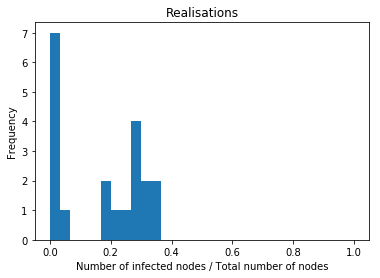

In [26]:
# run Monte Carlo simulations
Influences = []  #stores the total number of removed nodes in each run.
for i in range(sampleSize):
    reset(Gra) # initialise all nodes to succeptible
    initially_infected = initialise_infection_random(Gra, ini)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
# print  'the expected influence of the seed nodes is', np.average(Influences)
plotDistribution(Influences)

## Seeding initial nodes by degree

Rather than selecting initial spreaders (of information) according to the degree of nodes, the following function selects the nodes with the largest  (smallest) degree and start the spreading. 

The simulation result would exhibit the same bimodal behavior as well: either it does not spread out, or spreads out to 20% of the total network eventually. The interesting phenomenon is that the position of the larger peak is similar to the one of the random initialisation.


Infected: 0 time step: 274

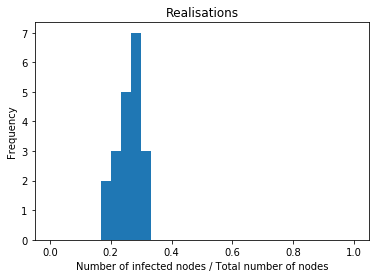

In [28]:
def initialise_infection_degree(G, num_to_infect, largest=True):
    degrees = dict(G.degree()) #get degrees of every node
    #below we sort the nodes in order of their degree, highest degree first.
    nodes_to_infect = []
    nodes_sorted_by_degree = sorted(degrees.items(), key=operator.itemgetter(1), reverse=largest) 
    for x in range(num_to_infect): 
        nodes_to_infect.append(nodes_sorted_by_degree[x])
    for n in nodes_to_infect:
        G.node[n[0]]['state'] = State.Infected
    return nodes_to_infect

# run Monte Carlo simulations
Influences = []  #stores the total number of removed nodes in each run.
for i in range(sampleSize):
    reset(Gra) # initialise all nodes to succeptible
    initially_infected = initialise_infection_degree(Gra, ini)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
# print  'the expected influence of the seed nodes is', np.average(Influences)
plotDistribution(Influences)

Infected: 0 time step: 628

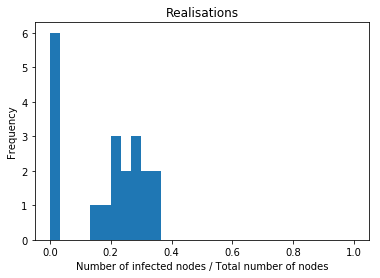

In [29]:
# run Monte Carlo simulations using the smallest degree nodes as seeds
Influences = []  #stores the total number of removed nodes in each run.
for i in range(sampleSize):
    reset(Gra) # initialise all nodes to succeptible
    initially_infected = initialise_infection_degree(Gra, ini, largest = False)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
# print  'the expected influence of the seed nodes is', np.average(Influences)
plotDistribution(Influences)

## Seeding initial nodes by betweenness centrality

An alternative way to do select the best set of nodes would be selecting the ones with the high betweenness centrality.

Again, the simulation result would exhibit the same bimodal behavior as well: either it does not spread out, or spreads out to 20% of the total network eventually.


Infected: 0 time step: 190

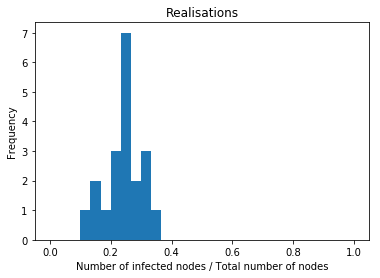

In [30]:
def initialise_infection_betweenness(G, num_to_infect, largest=True):
    #below we sort the nodes in order of their betweenness centrality, highest first.
    nodes_to_infect = []
    bet_cen = nx.betweenness_centrality(G)
    nodes_sorted_by_betweenness = sorted(bet_cen.items(), key=operator.itemgetter(1), reverse=largest)
    for x in range(num_to_infect): 
        nodes_to_infect.append(nodes_sorted_by_betweenness[x])
    for n in nodes_to_infect:
        G.node[n[0]]['state'] = State.Infected
    return nodes_to_infect

# run Monte Carlo simulations
Influences = []  #stores the total number of removed nodes in each run.
for i in range(sampleSize):
    reset(Gra) # initialise all nodes to succeptible
    initially_infected = initialise_infection_betweenness(Gra, ini)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
# print  'the expected influence of the seed nodes is', np.average(Influences)
plotDistribution(Influences)

## The bimodel behavior and the critical point

The physical reason behind this bimodal distribution is due to the existence of the so-called 'Giant Component' in the network. A 'Giant component' is the connected set of nodes through infection paths. Statistical mechanics analysis leads to the conclusion that the size (number of nodes) inside the giant component is unique when the size of the whole network is infinite. The peak on the right of the histogram has a position corresponding to the size of the giant component. Now it is clear why the position of that peak is around 0.2 regardless of the initialisation condition.

But there is a catch here. A message needs to go 'viral' to be considered as viral marketing. This 'viral' condition has a clear definition in complex networks, called critical threshold $\gamma_c$, where $\gamma = \beta/\alpha$ characterizing the spreading strength of the message. In the case of Erdos-Renyi networks, $\gamma_c=1/(\langle k \rangle -1)$. The message could never go viral if its $\gamma$ value is below the critical value; it has A CHANCE to go viral ONLY when $\gamma>\gamma_c$. We will see from the example of Erdos-Renyi network below.

## Below the critical threshold

The network has average degree 5, thus its critical threshold $\gamma_c=0.25$.
The transmission model has $\beta=0.01$ and $\alpha=0.5$, thus a $\gamma$ value smaller than the critical threshold, and we expect the spreading not be big.


Infected: 0 time step: 2

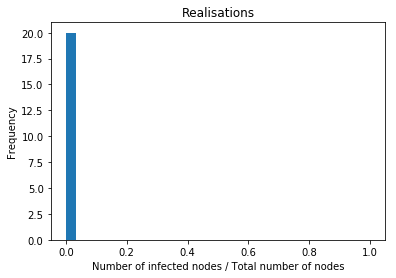

In [31]:
##############################################
#Initialise the network
N = 1000 # size of network to make
Gra = nx.erdos_renyi_graph(N,5.0/N) # create ER network with average degree 5.0
m = transmission_model_factory(0.01, 0.5) # create our transmission model
ini = 5 #initially infected number of nodes

# run Monte Carlo simulations
Influences = []  #stores the total number of removed nodes in each run.
for i in range(sampleSize):
    reset(Gra) # initialise all nodes to succeptible
    initially_infected = initialise_infection_random(Gra, ini)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
# print  'the expected influence of the seed nodes is', np.average(Influences)
plotDistribution(Influences)

## Above the critical threshold

Now we change the transmission model parameter to $\beta=0.15$ and $\alpha=0.5$, such that the $\gamma$ value is above the critical threshold. Here we would observe that some of the realisations reached a significant portion of the whole network.


Infected: 0 time step: 228

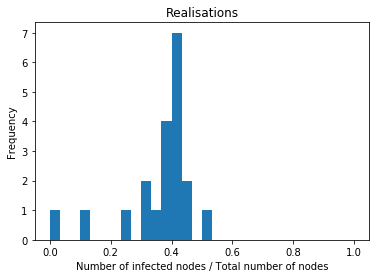

In [32]:
##############################################
#Initialise the network
N = 1000 # size of network to make
Gra = nx.erdos_renyi_graph(N,5.0/N) # create ER network with average degree 5.0
m = transmission_model_factory(0.15, 0.5) # create our transmission model
ini = 5 #initially infected number of nodes
# run Monte Carlo simulations
Influences = []  #stores the total number of removed nodes in each run.
for i in range(sampleSize):
    reset(Gra) # initialise all nodes to succeptible
    initially_infected = initialise_infection_random(Gra, ini)
    S, I, R, endtime, ii = run_spread_simulation(Gra, m, initially_infected)
    Influences.append(float(R[-1])/len(Gra))
# print  'the expected influence of the seed nodes is', np.average(Influences)
plotDistribution(Influences)

## A rigorous definition for viral marketing

From the phenomenon above, we see that viral spreading occurs only when the message reaches a certain threshold level of spreading strength $\gamma$. For any given network structure and model construct (SIR or linear threshold model etc.), there is a well-defined threshold that the message or disease can go "VIRAL". Such threshold can be mathematically proven and calculated.


## Computational time
The computational time in the above experiments is non-negligible. And that was only with 1000 nodes with a few thousand links in total. Imagine in the real social networks with total number of nodes in the order of 1,000,000,000, the computational time for a supercomputer would be years for the purpose of finding the best set of seed nodes. 

## Question:
Based on the bimodal distribution of the histograms, could you construct a method to significantly improve the computational runtime/complexity, in terms of estimating the number of finally removed nodes $\langle T \rangle$ from a given set of seed  nodes?



## Practical problem (for your interest)

The real social networks are much more complicated than BA or ER networks as exemplified above, with more intricate local and global structures like assortativity, clustering and communities; They are also much larger with up to billions of nodes for Facebook and Twitter. As a practice, please use the New Orleans Facebook network to study the information spreading over real social networks. 

The Facebook Network Data of New Orleans used in the 2009 research article 'On the Evolution of User Interaction in Facebook' by Bimal Viswanath and Alan Mislove and Meeyoung Cha and Krishna P. Gummadi, published in Proceedings of the 2nd ACM SIGCOMM Workshop on Social Networks (http://socialnetworks.mpi-sws.org/data-wosn2009.html).

## Find the set of 10 nodes that maximizes the final number of infected nodes

In [34]:
#import facebook network data
fh=open("facebook-links.txt","rb")
FB=nx.read_edgelist(fh,nodetype=int,data = False)
#check the total size of the network
N= len(FB.nodes()), 
#Get the largest index of the nodes
M=max(FB.nodes())
# print 'The Facebook network contains ', N[0] , ' nodes.'

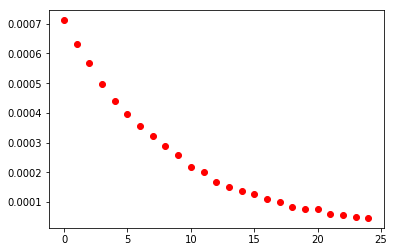

In [35]:
import matplotlib.pyplot as plt 
import numpy as np

Avr_rhos = [0.00071199999999999888, 0.00063267999999999571, 0.00056951999999999491, 0.00049603999999999816, 0.00043916000000000094, 0.00039640000000000042, 0.00035732000000000027, 0.00032335999999999677, 0.00028683999999999681, 0.00025691999999999648, 0.00021891999999999544, 0.00020119999999999535, 0.00016827999999999627, 0.00015123999999999601, 0.0001364399999999963, 0.00012531999999999702, 0.00011079999999999765, 9.8639999999997768e-05, 8.4239999999998136e-05, 7.699999999999866e-05, 7.6279999999998612e-05, 6.043999999999915e-05, 5.7559999999999225e-05, 5.0879999999999438e-05, 4.6239999999999544e-05]
plt.plot(range(25),Avr_rhos,'ro')
plt.show()